In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [49]:

class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

        self.classes_likelihoods = {}

    def build_classifier(self, train_features, train_classes, interval_count, classess_count):
        discrete_features = self.data_discretization(train_features, interval_count)
        attr_length = len(discrete_features[0])
        data_length = len(train_features)
        classes_counter = Counter(train_classes)
        for i in range(classess_count):
            self.likelihoods[i] = {}
            self.classes_likelihoods[i] = classes_counter[i] / data_length
            features_for_class = []
            for j in range(data_length):
                if train_classes[j] == i:
                    features_for_class.append(discrete_features[j])
            for j in range(attr_length):
                list = [value[j] for value in features_for_class]
                attrs_likelihoods = Counter(list)
                for k in range(attr_length):
                    try:
                        attrs_likelihoods[k] = attrs_likelihoods[k] / classes_counter[i]
                    except KeyError:
                        attrs_likelihoods[k] = 0
                self.likelihoods[i][j] = attrs_likelihoods

    @staticmethod
    def data_discretization(data, interval_count):
        discrete_data = []
        borders_lists = []
        data_length = len(data)
        attr_length = len(data[0])
        for i in range(attr_length):
            list = [value[i] for value in data]
            list.sort()
            borders = []
            for i in range(interval_count - 1):
                borders.append(list[int(data_length*(i+1)/interval_count)])
            borders_lists.append(borders)

        for record in data:
            discrete_record = []
            for i in range(attr_length):
                value = record[i]
                for j in range(interval_count - 1):
                    added = False
                    if value <= borders_lists[i][j] and not added:
                        discrete_record.append(j)
                        added = True
                        break
                    elif value > borders_lists[i][-1] and not added:
                        discrete_record.append(interval_count-1)
                        added = True
                        break
            discrete_data.append(discrete_record)
        return discrete_data



    def predict(self, sample):
        likelihoods = {}
        sum = 0
        for i in range(len(self.classes_likelihoods)):
            class_likelihood = self.classes_likelihoods[i]
            for j in range(len(sample)):
                class_likelihood = class_likelihood * self.likelihoods[i][j][sample[j]]
                # sum of log avlues instead of multiplications could be used
            sum += class_likelihood
            likelihoods[i] = class_likelihood
        return likelihoods # likelihoods are not normalized -> not adding up to 1

class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

        self.classes_likelihoods = {}

    def build_classifier(self, train_features, train_classes, classess_count):
        attr_length = len(train_features[0])
        data_length = len(train_features)
        classes_counter = Counter(train_classes)
        for i in range(classess_count):
            self.likelihoods[i] = {}
            self.classes_likelihoods[i] = classes_counter[i] / data_length
            features_for_class = []
            for j in range(data_length):
                if train_classes[j] == i:
                    features_for_class.append(train_features[j])
            for j in range(attr_length):
                self.likelihoods[i][j] = {}
                list = [value[j] for value in features_for_class]
                self.likelihoods[i][j]['mean'] = np.mean(list)
                self.likelihoods[i][j]['std'] = np.std(list)


    @staticmethod
    def normal_dist(x, mean, std):
        return (1.0 / (std * math.sqrt(2*math.pi))) * math.exp(-0.5*((x - mean) / std) ** 2)


    def predict(self, sample):
        likelihoods = {}
        likelihoods_normalized = {}
        sum = 0
        for i in range(len(self.classes_likelihoods)):
            class_likelihood = self.classes_likelihoods[i]
            for j in range(len(sample)):

                mean = self.likelihoods[i][j]['mean']
                std = self.likelihoods[i][j]['std']
                class_likelihood = class_likelihood * self.normal_dist(sample[j], mean, std)

            sum += class_likelihood
            likelihoods[i] = class_likelihood
        for i in range(len(self.classes_likelihoods)):
            likelihoods_normalized[i] = likelihoods[i] / sum
        return likelihoods_normalized

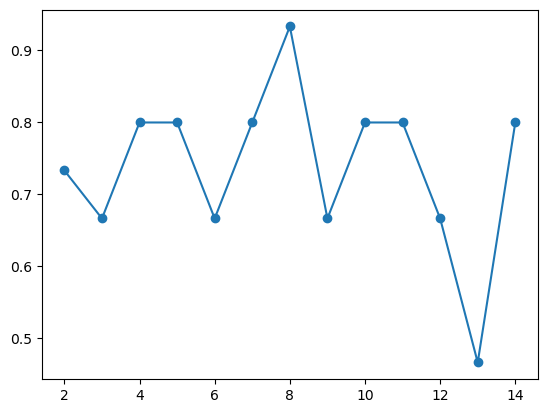

In [50]:
iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123) #random_state=123


naive_bayes = NaiveBayes()

intervals_counts = [i for i in range(15) if i > 1]
accuracies = []
verbose = 0

for intervals in intervals_counts:
    naive_bayes.build_classifier(x_train, y_train, intervals, 3)
    x_test_discrete = naive_bayes.data_discretization(x_test, intervals)
    predictions = []
    for sample, gt in zip(x_test_discrete, y_test):
        likelihoods = naive_bayes.predict(sample)
        prediction = max(likelihoods, key=likelihoods.get)
        predictions.append(prediction)
        if verbose:
            print(f'Prediction: {predictions[-1]}; Real class: {gt}')
    accuracy = np.mean(predictions == y_test)
    if verbose:
        print(f"Accuracy: {accuracy}")
    accuracies.append(accuracy)
plt.plot(intervals_counts, accuracies)
plt.scatter(intervals_counts, accuracies)
plt.show()


In [52]:
iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123) #random_state=123


gaussian_naive_bayes = GaussianNaiveBayes()
gaussian_naive_bayes.build_classifier(x_train, y_train, 3)

verbose = 1

for i in range(5):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1) #random states
    predictions = []
    for sample, gt in zip(x_test, y_test):
        likelihoods = gaussian_naive_bayes.predict(sample)
        prediction = max(likelihoods, key=likelihoods.get)
        predictions.append(prediction)
        if verbose == 2:
            print(f'Prediction: {predictions[-1]}; Real class: {gt}')
    accuracy = np.mean(predictions == y_test)
    if verbose == 1:
        print(f"Accuracy: {accuracy}")




Accuracy: 0.8666666666666667
Accuracy: 0.9333333333333333
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
